In [8]:
import numpy                 as np
import pandas                as pd
import matplotlib.pyplot     as plt
import seaborn               as sns
import statsmodels.api       as sm
import seaborn               as sns
import scanpy                as sc
from statsmodels.formula.api import ols
from scipy.stats             import hypergeom

from matplotlib_venn         import  venn2, venn3

from plotting import wedge_plot

def safe_div(x,y):
    if y == 0:
        return np.array([0])
    return x / y


def calculate_enrichment(hit_list, top_genes, full_gene_list):
    x = sum(pd.DataFrame(top_genes).isin(hit_list).values) # how many top genes in cell list
    n = sum(pd.DataFrame(hit_list).isin(full_gene_list).values)[0] # how many cell genes in full list
    N = len(top_genes)  # number of samples
    M = len(full_gene_list)  # total number in population

    enrichment = safe_div( (x/N) , ((n-x) / (M-N)) )
    p = hypergeom.sf(x-1, M, n, N)

    return enrichment, p


# dictionaries ###############################################################################3
# tissue zone names
tissue_dict = {'cortical_plate':'0.cortical_plate',
               'subplate': '1.subplate',
               'intermediate': '2.intermediate',
               'subventricular': '3.subventricular',
               'ventricular': '4.ventricular'}

# location to save outputs
output_dir = 'OUTPUTS/'
results_dir = 'RESULTS/'

# data
anova_results = pd.read_csv('{:}/all-genes-ANOVA-results.csv'.format(output_dir))
ZONE_genes = pd.read_csv('{:}/ZONE-genes-anova-results.csv'.format(output_dir))
REGION_genes = pd.read_csv('{:}/REGION-genes-anova-results.csv'.format(output_dir))
TIMEPOINT_genes = pd.read_csv('{:}/TIMEPOINT-genes-anova-results.csv'.format(output_dir))
microarray_data = pd.read_csv('{:}/microarray-data-for-ANOVA.csv'.format(output_dir))

ZRT_genelist = list(np.loadtxt('{:}/all-ZRT-genes.txt'.format(results_dir), dtype='str'))
all_microarray_genelist = list(np.loadtxt('{:}/all-microarray-genes.txt'.format(results_dir), dtype='str'))


# other data
brainvar = pd.read_csv('BRAINVAR/brainvar_data.csv') # from supplemental data
# cell type enrichment
cluster_markers = pd.read_csv('POLIOUDAKIS/cluster_genes.csv') # from supplemental data
# load singlecell data
scdata = sc.read('BHADURI/local.h5ad', backed='r') # download from https://cellxgene.cziscience.com/collections/c8565c6a-01a1-435b-a549-f11b452a83a8
scdata.file.close()

# load cluster ids from Bhaduri supplemental materials
cell_meta = pd.read_csv('BHADURI/Table_S5.csv', low_memory=False)# from supplemental data
marker_genes = pd.read_csv('BHADURI/Table_S6.csv')# from supplemental data

# fontsize
FNT = 18

## Characterisation of ZRT genes


Of 2145 genes with a significant main effect of TIME (FDR p<0.01)
1813 genes increased from early to mid gestation
332 genes decreased from early to mid gestation

see: /data/gareth.ball/micro-brain/ANALYSIS/OUTPUTS//ZRT-increasing-genes.csv
see: /data/gareth.ball/micro-brain/ANALYSIS/OUTPUTS//ZRT-decreasing-genes.csv


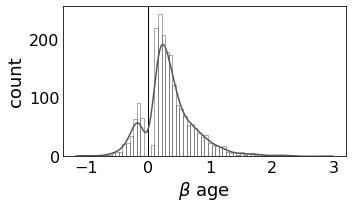

In [9]:
# combine Z, R, T dataframes
ZRT_genes = pd.concat((ZONE_genes[ZONE_genes['gene'].isin(ZRT_genelist)],
                       REGION_genes[REGION_genes['gene'].isin(ZRT_genelist)],
                       TIMEPOINT_genes[TIMEPOINT_genes['gene'].isin(ZRT_genelist)]))
ZRT_genes = ZRT_genes.drop_duplicates()

print('Of {:} genes with a significant main effect of TIME (FDR p<0.01)'.format(len(ZRT_genes)))
print('{:} genes increased from early to mid gestation'.format(sum(ZRT_genes['C_age']>0)))
print('{:} genes decreased from early to mid gestation'.format(sum(ZRT_genes['C_age']<0)))

# save out gene lists
print('')
print('see: {:}/ZRT-increasing-genes.csv'.format(output_dir))
print('see: {:}/ZRT-decreasing-genes.csv'.format(output_dir))

ZRT_genes[ZRT_genes['C_age']>0][['gene', 'C_age']].to_csv('{:}/ZRT-increasing-genes.csv'.format(output_dir), index=None)
ZRT_genes[ZRT_genes['C_age']<0][['gene', 'C_age']].to_csv('{:}/ZRT-decreasing-genes.csv'.format(output_dir), index=None)


# PLOT AGE EFFECTS ######################################################################################
fig, ax = plt.subplots(1,1,figsize=(5,3))
sns.histplot(x='C_age', data=ZRT_genes, ax=ax, fill=False, kde=True, color='#575656')
ax.set_xlabel(r'$\beta$ age', fontsize=FNT)
ax.set_ylabel('count', fontsize=FNT)
ax.tick_params('both', labelsize=FNT-2, length=0)
ax.axvline(0, color='black', lw=1, zorder=0)
plt.tight_layout()
plt.savefig('{:}/ZRT-age-effects.png'.format(results_dir), dpi=300, transparent=False, facecolor='white')

#### Comparison to BrainVar
[BrainVar](https://www.cell.com/cell-reports/fulltext/S2211-1247(20)30367-3) paper previously identified sets of 'Rising' and 'Falling' genes, with expression levels that change significantly during brain development in the DLPFC. 

Of 1920 overlapping genes:
803 41.82% are classified as Rising (compared to 29.16% in BrainVar)
385 20.05% are classified as Falling (compared to 21.63% in BrainVar)

enrichment of ZRT in rising genes: 1.69 p=0.0000

ANOVA  results: expression ~ group
               sum_sq      df          F        PR(>F)
group      769.626129     2.0  84.045759  1.027699e-35
Residual  8777.202473  1917.0        NaN           NaN


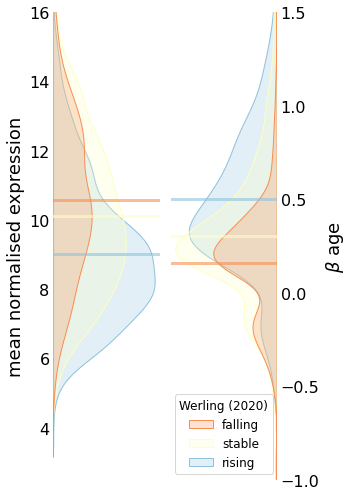

In [10]:
# load brainvar data
brainvar = pd.read_csv('MICROARRAY_DATA/BRAINVAR/brainvar_data.csv')
brainvar_dict = dict(zip(brainvar['GeneSymbol'], brainvar['Trajectory_group']))

# get expression data for all ZRT genes overlapping with brainVar at early timepoint
micro_df = microarray_data[(microarray_data['gene'].isin(brainvar['GeneSymbol'])) & 
                            (microarray_data['gene'].isin(ZRT_genelist)) &
                            (microarray_data['timepoint']=='early')].copy()

# average gene expression over regions and tissue
micro_df = micro_df.drop('DS', axis=1).groupby(by='gene').mean().reset_index()
# add brainvar group to each gene
micro_df['group'] = micro_df['gene'].map(brainvar_dict)

print('Of {:} overlapping genes:'.format(len(micro_df)))
num_rising = (micro_df['group']=='Rising').sum()
num_bv_rising = (brainvar['Trajectory_group']=='Rising').sum()
print('{:} {:.2f}% are classified as Rising (compared to {:.2f}% in BrainVar)'.format(num_rising, 100*(num_rising/len(micro_df)), 100*(num_bv_rising/len(brainvar))))
num_falling = (micro_df['group']=='Falling').sum()
num_bv_falling = (brainvar['Trajectory_group']=='Falling').sum()
print('{:} {:.2f}% are classified as Falling (compared to {:.2f}% in BrainVar)'.format(num_falling, 100*(num_falling/len(micro_df)), 100*(num_bv_falling/len(brainvar))))
print('')

# enrichment of ZRT in rising genes
e,p = calculate_enrichment(brainvar[brainvar['Trajectory_group']=='Rising']['GeneSymbol'].tolist(), ZRT_genelist, all_microarray_genelist)
print('enrichment of ZRT in rising genes: {:.02f} p={:.04f}'.format(e[0], p[0]))
print('')

# average age effect for each gene
age_effects = ZRT_genes[['gene', 'C_age']].copy()
# add brainvar group
age_effects['group'] = age_effects['gene'].map(brainvar_dict)

# test if expression level at 15/16w differs between BrainVar groups
lm = ols('expression ~ group', data=micro_df).fit()
table = sm.stats.anova_lm(lm, typ=2) 
print('ANOVA  results: expression ~ group')
print(table)

/group/deve2/data/gareth.ball/brainAtlas/pix2pix_env/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/group/deve2/data/gareth.ball/brainAtlas/pix2pix_env/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


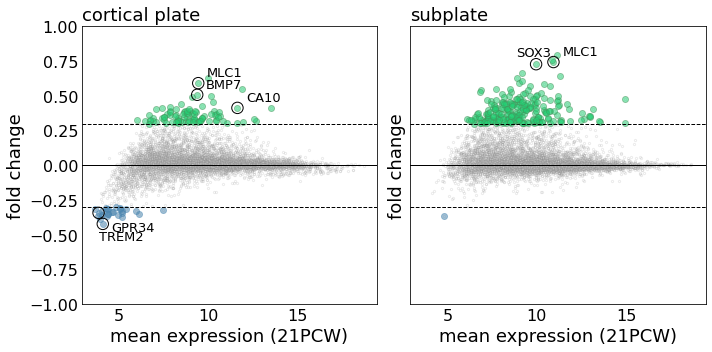

In [11]:
## PLOTTING UP AND DOWN REGULATED GENES IN EACH TISSUE ZONE
tissue_dict = {'0.cortical_plate':'cortical_plate',
               '1.subplate': 'subplate',
               '2.intermediate': 'intermediate',
               '3.subventricular': 'subventricular',
               '4.ventricular': 'ventricular'}
data = pd.read_csv('OUTPUTS/microarray-data-for-ANOVA.csv')


fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=True)

# fold change threshold for up and down genes
thr = 0.3

cell_enrichments = []
up_genes = []
down_genes = []

df = []
for n, zone in  enumerate(['0.cortical_plate', '1.subplate']):
    # get data for each tissue zone
    tissue_data = data[data['tissue']==zone]
    plot_data = tissue_data.drop('DS', axis='columns').groupby(by=['timepoint', 'gene']).mean().reset_index()

    # diff expression
    early_data = plot_data[plot_data['timepoint']=='early']
    mid_data = plot_data[plot_data['timepoint']=='mid']

    # difference between mid and early
    early_data['diff'] = np.log2(mid_data['expression'].values) - np.log2(early_data['expression'].values)

    # plots
    ax[n].scatter(mid_data['expression'], early_data['diff'], s=5, alpha=.15, edgecolor='grey',facecolor='white')
    big_diff = early_data['diff']>np.log2(2**thr)
    big_neg_diff = early_data['diff'] < np.log2(2**-thr)

    ax[n].scatter(mid_data[big_diff.values]['expression'], early_data[big_diff.values]['diff'],alpha=.5, edgecolor='#44935b',c='#21d375')
    ax[n].scatter(mid_data[big_neg_diff.values]['expression'], early_data[big_neg_diff.values]['diff'],alpha=.5, color='#4884af')
    
    # format
    ax[n].axhline(0, lw=1, color='black')
    ax[n].axhline(np.log2(2**thr), lw=1, color='black', linestyle='--')
    ax[n].axhline(np.log2(2**-thr), lw=1, color='black', linestyle='--')
    ax[n].set_title(tissue_dict[zone].replace('_', ' '), fontsize=18, loc='left')
    ax[n].tick_params('both', length=0, labelsize=16)
    ax[n].set_xlabel('mean expression (21PCW)'.format(tissue_dict[zone].replace('_', ' ')), fontsize=18)
    ax[n].set_ylabel('fold change', fontsize=18)
    ax[n].set_ylim(-1,1)
    
    df.append([early_data, mid_data])

    # cell enrichments for up and down genes
    all_genes = []
    all_clusters = []
    for c in list(cluster_markers['Cluster'].unique()):
        all_genes.append(list(cluster_markers[cluster_markers['Cluster']==c]['Gene']))
        all_clusters.append(c)

    up_score = []
    down_score = []
    for n_clust,c in enumerate(list(cluster_markers['Cluster'].unique())):
        e,p = calculate_enrichment(all_genes[n_clust], list(early_data[big_diff.values]['gene']), list(data['gene'].unique()))
        up_score.append([e[0],p[0]])
        e,p = calculate_enrichment(all_genes[n_clust], list(early_data[big_neg_diff.values]['gene']), list(data['gene'].unique()))
        down_score.append([e[0],p[0]])

    enrichments = pd.concat((pd.DataFrame(up_score), pd.DataFrame(down_score)), axis=1)
    enrichments.columns = ['up_enrichment', 'up_p', 'down_enrichment', 'down_p']
    enrichments.insert(0, 'tissue', zone)
    enrichments.insert(0, 'clusters', all_clusters)
    cell_enrichments.append(enrichments)
    
cell_enrichments = pd.concat(cell_enrichments)

# add details for interesting genes
# interesting genes - up -  CP
i_genes = ['MLC1',  'BMP7', 'CA10']
for i in i_genes:
    ax[0].scatter(df[0][1][df[0][1]['gene']==i]['expression'], df[0][0][df[0][0]['gene']==i]['diff'], s=130 ,edgecolor='black',facecolor='none')
    ax[0].text(df[0][1][df[0][1]['gene']==i]['expression']+.5, df[0][0][df[0][0]['gene']==i]['diff']+.05, i, fontsize=13)

# interesting genes - down -  CP
i_genes = ['GPR34']
for i in i_genes:
    ax[0].scatter(df[0][1][df[0][1]['gene']==i]['expression'], df[0][0][df[0][0]['gene']==i]['diff'], s=130 ,edgecolor='black',facecolor='none')
    ax[0].text(df[0][1][df[0][1]['gene']==i]['expression']+.5, df[0][0][df[0][0]['gene']==i]['diff']-.05, i, fontsize=13)
i_genes = ['TREM2']
for i in i_genes:
    ax[0].scatter(df[0][1][df[0][1]['gene']==i]['expression'], df[0][0][df[0][0]['gene']==i]['diff'], s=130 ,edgecolor='black',facecolor='none')
    ax[0].text(df[0][1][df[0][1]['gene']==i]['expression'], df[0][0][df[0][0]['gene']==i]['diff']-.2, i, fontsize=13)
        
# interesting genes - up -  SP
i_genes = ['MLC1']
for i in i_genes:
    ax[1].scatter(df[1][1][df[1][1]['gene']==i]['expression'], df[1][0][df[1][0]['gene']==i]['diff'], s=130 ,edgecolor='black',facecolor='none')
    ax[1].text(df[1][1][df[1][1]['gene']==i]['expression']+.5, df[1][0][df[1][0]['gene']==i]['diff']+.05, i, fontsize=13)
i_genes = ['SOX3']
for i in i_genes:
    ax[1].scatter(df[1][1][df[1][1]['gene']==i]['expression'], df[1][0][df[1][0]['gene']==i]['diff'], s=130 ,edgecolor='black',facecolor='none')
    ax[1].text(df[1][1][df[1][1]['gene']==i]['expression']-1.1, df[1][0][df[1][0]['gene']==i]['diff']+.06, i, fontsize=13)

plt.tight_layout()
plt.savefig('RESULTS/up-down-genes-by-time-CP-SP.png', dpi=300, transparent=False, facecolor='white')
cell_enrichments.to_csv('OUTPUTS/polioudakis-cell-enrichment-CP-SP-up-down-genes-by-time.csv', index=None)

/group/deve2/data/gareth.ball/brainAtlas/pix2pix_env/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/group/deve2/data/gareth.ball/brainAtlas/pix2pix_env/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


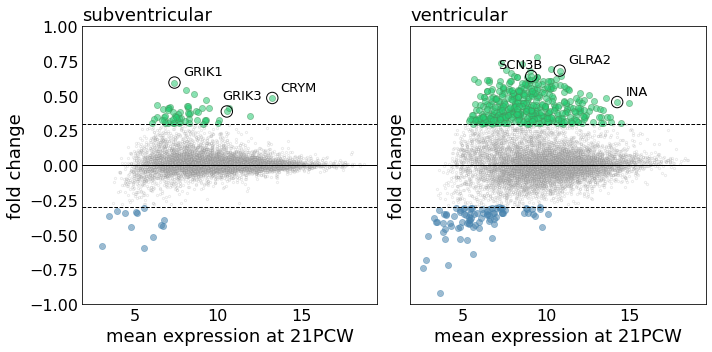

In [12]:
## PLOTTING UP AND DOWN REGULATED GENES IN EACH TISSUE ZONE

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=True)

cell_enrichments = []
up_genes = []
down_genes = []

df = []
for n, zone in  enumerate(['3.subventricular', '4.ventricular']):
    # get data for each tissue zone
    tissue_data = data[data['tissue']==zone]
    plot_data = tissue_data.drop('DS', axis='columns').groupby(by=['timepoint', 'gene']).mean().reset_index()

    # diff expression
    early_data = plot_data[plot_data['timepoint']=='early']
    mid_data = plot_data[plot_data['timepoint']=='mid']

    # difference between mid and early
    early_data['diff'] = np.log2(mid_data['expression'].values) - np.log2(early_data['expression'].values)

    # plots
    ax[n].scatter(mid_data['expression'], early_data['diff'], s=5, alpha=.15, edgecolor='grey',facecolor='white')
    big_diff = early_data['diff']>np.log2(2**thr)
    big_neg_diff = early_data['diff'] < np.log2(2**-thr)
    
    # plot
    ax[n].scatter(mid_data[big_diff.values]['expression'], early_data[big_diff.values]['diff'],alpha=.5, edgecolor='#44935b',c='#21d375')
    ax[n].scatter(mid_data[big_neg_diff.values]['expression'], early_data[big_neg_diff.values]['diff'],alpha=.5, color='#4884af')
    
    # format
    ax[n].axhline(0, lw=1, color='black')
    ax[n].axhline(np.log2(2**thr), lw=1, color='black', linestyle='--')
    ax[n].axhline(np.log2(2**-thr), lw=1, color='black', linestyle='--')
    ax[n].set_title(tissue_dict[zone].replace('_', ' '), fontsize=18, loc='left')
    ax[n].tick_params('both', length=0, labelsize=16)
    ax[n].set_xlabel('mean expression at 21PCW'.format(tissue_dict[zone].replace('_', ' ')), fontsize=18)
    ax[n].set_ylabel('fold change', fontsize=18)
    
    ax[n].set_ylim(-1,1)
    
    df.append([early_data, mid_data])

    # cell enrichments for up and down genes
    all_genes = []
    all_clusters = []
    for c in list(cluster_markers['Cluster'].unique()):
        all_genes.append(list(cluster_markers[cluster_markers['Cluster']==c]['Gene']))
        all_clusters.append(c)

    up_score = []
    down_score = []
    for n_clust,c in enumerate(list(cluster_markers['Cluster'].unique())):
        e,p = calculate_enrichment(all_genes[n_clust], list(early_data[big_diff.values]['gene']), list(data['gene'].unique()))
        up_score.append([e[0],p[0]])
        e,p = calculate_enrichment(all_genes[n_clust], list(early_data[big_neg_diff.values]['gene']), list(data['gene'].unique()))
        down_score.append([e[0],p[0]])

    enrichments = pd.concat((pd.DataFrame(up_score), pd.DataFrame(down_score)), axis=1)
    enrichments.columns = ['up_enrichment', 'up_p', 'down_enrichment', 'down_p']
    enrichments.insert(0, 'tissue', zone)
    enrichments.insert(0, 'clusters', all_clusters)
    cell_enrichments.append(enrichments)
    

cell_enrichments = pd.concat(cell_enrichments)

# interesting genes - up -  SUB
i_genes = ['CRYM', 'GRIK1']
for i in i_genes:
    ax[0].scatter(df[0][1][df[0][1]['gene']==i]['expression'], df[0][0][df[0][0]['gene']==i]['diff'], s=130 ,edgecolor='black',facecolor='none')
    ax[0].text(df[0][1][df[0][1]['gene']==i]['expression']+.5, df[0][0][df[0][0]['gene']==i]['diff']+.05, i, fontsize=13)
i_genes = ['GRIK3']
for i in i_genes:
    ax[0].scatter(df[0][1][df[0][1]['gene']==i]['expression'], df[0][0][df[0][0]['gene']==i]['diff'], s=130 ,edgecolor='black',facecolor='none')
    ax[0].text(df[0][1][df[0][1]['gene']==i]['expression']-.3, df[0][0][df[0][0]['gene']==i]['diff']+.085, i, fontsize=13)

# interesting genes - up -  VEN
i_genes = ['GLRA2', 'INA']
for i in i_genes:
    ax[1].scatter(df[1][1][df[1][1]['gene']==i]['expression'], df[1][0][df[1][0]['gene']==i]['diff'], s=130 ,edgecolor='black',facecolor='none')
    ax[1].text(df[1][1][df[1][1]['gene']==i]['expression']+.5, df[1][0][df[1][0]['gene']==i]['diff']+.05, i, fontsize=13)
i_genes = ['SCN3B']
for i in i_genes:
    ax[1].scatter(df[1][1][df[1][1]['gene']==i]['expression'], df[1][0][df[1][0]['gene']==i]['diff'], s=130 ,edgecolor='black',facecolor='none')
    ax[1].text(df[1][1][df[1][1]['gene']==i]['expression']-2, df[1][0][df[1][0]['gene']==i]['diff']+.06, i, fontsize=13)

    
plt.tight_layout()
plt.savefig('RESULTS/up-down-genes-by-time-SVZ-VZ.png', dpi=300, transparent=False, facecolor='white')
cell_enrichments.to_csv('OUTPUTS/polioudakis-cell-enrichment-SVZ-VZ-up-down-genes.csv', index=None)

### Cell type enrichment of ZRT genes
Using data from [457,965](https://www.nature.com/articles/s41586-021-03910-8) cells isolated from different areas of mid-gestation fetal cortex, we can measure expression of ZRT genes in specific cell types

final number of cells: 349015
see: /data/gareth.ball/micro-brain/ANALYSIS/RESULTS//ZRT-cell-type-enrichment.csv
see: /data/gareth.ball/micro-brain/ANALYSIS/RESULTS//ZRT-cell-cluster-enrichment.csv

see: /data/gareth.ball/micro-brain/ANALYSIS/OUTPUTS//scRNA-database.csv
see /data/gareth.ball/micro-brain/ANALYSIS/RESULTS//ZRT-UMAP-cell-type-enrichment.png


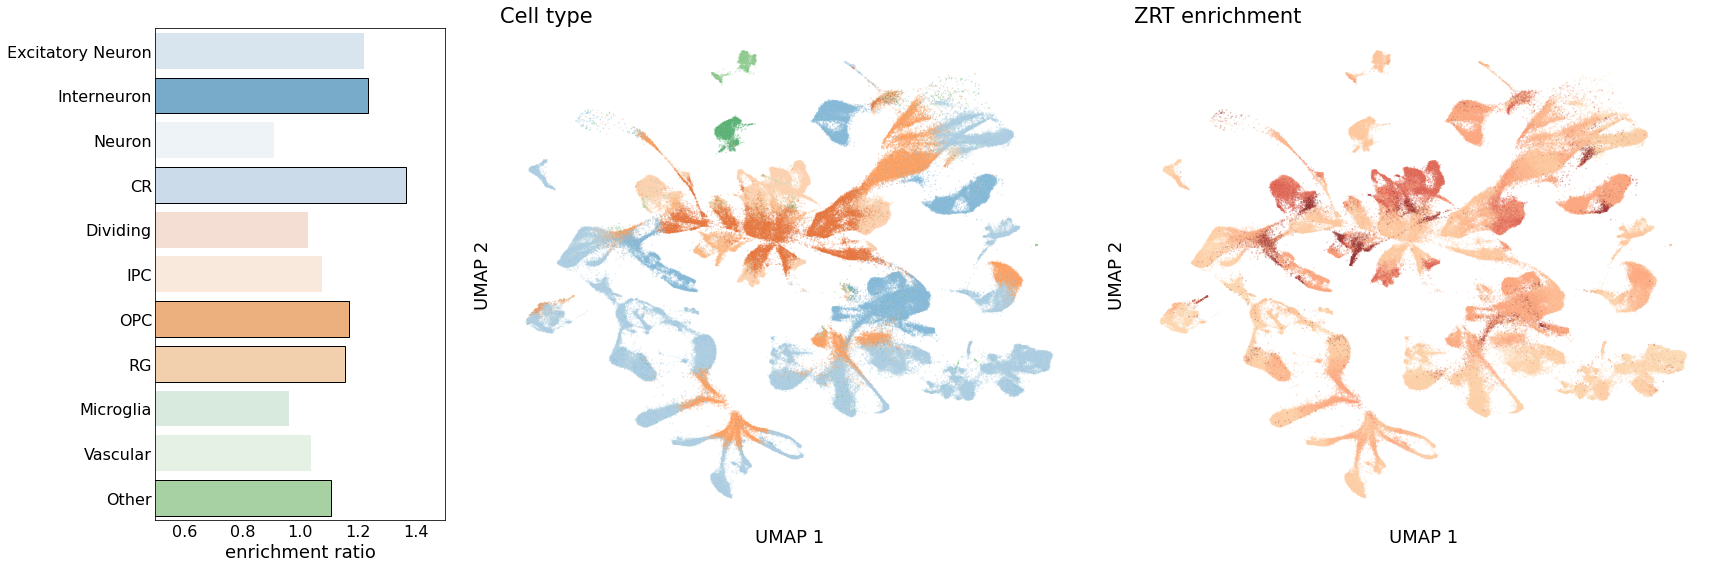

In [13]:
# get umap coordinates
umap1 = scdata.obsm['X_umap'][:,0]
umap2 = scdata.obsm['X_umap'][:,1]

# get cell variables
cluster_label = np.asarray(scdata.obs['cluster_label'])
cell_type = np.asarray(scdata.obs['cell_type'])
cortical_area = np.asarray(scdata.obs['cortical_area'])
tissue_zone = np.asarray(scdata.obs['lamina'])

# get gene symbols
genes = np.asarray(scdata.var['feature_name'])

# fix interneuron spelling
spelling_dict = dict(zip(['Inteneuron_combo2_1', 'Inteneuron_combo2_2','Inteneuron_combo2_3', 'Inteneuron_combo2_4', 'Inteneuron_combo2_5', 'Inteneuron_combo2_6', 'Inteneuron_combo2_7', 'Inteneuron_combo2_8','Inteneuron_combo2_9'],
                         ['Interneuron_combo2_1', 'Interneuron_combo2_2', 'Interneuron_combo2_3', 'Interneuron_combo2_4', 'Interneuron_combo2_5', 'Interneuron_combo2_6', 'Interneuron_combo2_7', 'Interneuron_combo2_8', 'Interneuron_combo2_9']))
for i in spelling_dict.keys():
    marker_genes.loc[marker_genes['cluster'] == i,'cluster'] = spelling_dict[i]
    
    
# collate into dataframe
cell_df = pd.DataFrame((scdata.obs.index, scdata.obs.cell_type, scdata.obs.cortical_area, umap1, umap2)).T
cell_df.columns = ['cell', 'type', 'cortical area', 'umap1', 'umap2']


# add in cell clusters defined in Bhaduri
consensus_dict = dict(zip(cell_meta['Cell Name'], cell_meta['ConsensusCellType - Final']))
cluster_dict = dict(zip(cell_meta['Cell Name'], cell_meta['CombinedCluster - Final']))
cell_df['cluster_type'] = cell_df['cell'].map(consensus_dict)
cell_df['cluster'] = cell_df['cell'].map(cluster_dict)


# keep only cells with defined clusters (remove NaN or cluster=0)
cell_df = cell_df[~((pd.isna(cell_df['cluster_type'])) | (cell_df['cluster_type']=='0'))]
print('final number of cells: {:}'.format(len(cell_df)))

# gather marker gene lists ####################################################################################
# gene markers for each cluster
all_clus = []
all_markers = []
for clus in cell_df['cluster'].unique():
    all_clus.append(clus)
    all_markers.append(marker_genes[marker_genes['cluster'] == clus]['gene'].values)

cluster_markers = pd.DataFrame((all_clus, all_markers)).T
cluster_markers.columns = ['cluster', 'markers']


# gather clusters into cell types
cluster_to_type = dict(zip(cell_df['cluster'], cell_df['cluster_type']))
cluster_markers['type'] = cluster_markers['cluster'].map(cluster_to_type)

# all gene markers for all clusters in each cell type
all_types = []
all_markers = []
for t in cluster_markers['type'].unique():
    all_types.append(t)
    marker_list = list(np.unique(np.concatenate(cluster_markers[cluster_markers['type']==t]['markers'].values)))
    # remove dates!
    marker_list = [mm for mm in marker_list if ('Sep' not in mm) and ('Mar' not in mm)]
    all_markers.append(marker_list)

type_markers = pd.DataFrame((all_types, all_markers)).T
type_markers.columns = ['type', 'markers']



# CELL TYPE ENRICHMENT #####################################################################################################
# calculate cell type enrichment for ZRT genes
cells = []
enrichment = []
ps = []
for cell in type_markers['type']:
    cells.append(cell)
    if len(type_markers[type_markers['type']==cell]['markers'].tolist()[0]) > 0:
        e,p = calculate_enrichment(type_markers[type_markers['type']==cell]['markers'].tolist()[0], ZRT_genelist, all_microarray_genelist)
        enrichment.append(e[0])
        ps.append(p[0])
    else:
        enrichment.append(np.nan)
        ps.append(np.nan)

cell_type_enrichment = pd.DataFrame((cells, enrichment, ps)).T
cell_type_enrichment.columns = ['cell type', 'enrichment ratio', 'p']
print('see: {:}/ZRT-cell-type-enrichment.csv'.format(results_dir))
cell_type_enrichment.to_csv('{:}/ZRT-cell-type-enrichment.csv'.format(results_dir), index=None)

# calculate cluster enrichment for ZRT genes
cells = []
enrichment = []
ps = []
for cell in cluster_markers['cluster']:
    cells.append(cell)
    if len(cluster_markers[cluster_markers['cluster']==cell]['markers'].tolist()[0]) > 0:
        e,p = calculate_enrichment(cluster_markers[cluster_markers['cluster']==cell]['markers'].tolist()[0], ZRT_genelist, all_microarray_genelist)
        enrichment.append(e[0])
        ps.append(p[0])
    else:
        enrichment.append(np.nan)
        ps.append(np.nan)

cell_cluster_enrichment = pd.DataFrame((cells, enrichment, ps)).T
cell_cluster_enrichment.columns = ['cell cluster', 'enrichment ratio', 'p']
cell_cluster_enrichment['cell type'] = cell_cluster_enrichment['cell cluster'].map(cluster_to_type)
print('see: {:}/ZRT-cell-cluster-enrichment.csv'.format(results_dir))
cell_cluster_enrichment.to_csv('{:}/ZRT-cell-cluster-enrichment.csv'.format(results_dir), index=None)


# PLOT #######################################################################################################
display_order = ['Excitatory Neuron', 'Interneuron', 'Neuron', 'CR', 
                 'Dividing', 'IPC', 'OPC', 'RG', 
                 'Microglia', 'Vascular', 'Other']
palette = 'tab20c'

cluster_enrichment_dict = dict(zip(cell_cluster_enrichment['cell cluster'], cell_cluster_enrichment['enrichment ratio']))
cell_df['zrt_enrichment'] = cell_df['cluster'].map(cluster_enrichment_dict)


# barplot
fig, ax = plt.subplots(1,3, figsize=(24,8), gridspec_kw={'width_ratios': (1,2,2)})
sns.barplot(y='cell type', x='enrichment ratio', edgecolor='black', data=cell_type_enrichment, order=display_order, palette=palette, ax=ax[0])
ax[0].set_xlim(0.5, 1.5)

# highlight significant enrichment
for n, patch in enumerate(ax[0].patches):
    if (cell_type_enrichment[cell_type_enrichment['cell type']==display_order[n]]['p'].values > 0.01):
        patch.set_alpha(0.2)
        patch.set_edgecolor('none')
        
ax[0].tick_params('both', labelsize=FNT-2, length=0)
ax[0].set_xlabel('enrichment ratio', fontsize=FNT)
ax[0].set_ylabel('')

# UMAPS
sns.scatterplot(x='umap1', y='umap2', hue='cluster_type', hue_order=display_order, 
                s=2, alpha=0.3, legend=False, data=cell_df, palette=palette, ax=ax[1])
sns.scatterplot(x='umap1', y='umap2', hue='zrt_enrichment',
                s=2, alpha=0.3, legend=False, data=cell_df, palette='OrRd', ax=ax[2])

ax[1].set_title('Cell type', fontsize=FNT+3, loc='left')
ax[2].set_title('ZRT enrichment', fontsize=FNT+3, loc='left')

for a in [ax[1], ax[2]]:
    sns.despine(ax=a, left=True, bottom=True)
    a.set_xlabel('UMAP 1', fontsize=FNT)
    a.set_ylabel('UMAP 2', fontsize=FNT)
    a.tick_params(length=0)
    a.set_xticklabels([])
    a.set_yticklabels([])
    
plt.tight_layout()    

print('')
print('see: {:}/scRNA-database.csv'.format(output_dir))
cell_df.to_csv('{:}/scRNA-database.csv'.format(output_dir), index=None)
print('see {:}/ZRT-UMAP-cell-type-enrichment.png'.format(results_dir))
plt.savefig('{:}/ZRT-UMAP-cell-type-enrichment.png'.format(results_dir), dpi=300, transparent=False, facecolor='white')


### ZRT gene identities

In [17]:
is_rg = []
for g in ZRT_genelist:
    if g in type_markers[type_markers['type']=='RG']['markers'].tolist()[0]:
        is_rg.append(1)
    else:
        is_rg.append(0)
        
is_opc = []
for g in ZRT_genelist:
    if g in type_markers[type_markers['type']=='OPC']['markers'].tolist()[0]:
        is_opc.append(1)
    else:
        is_opc.append(0)
        
is_inter = []
for g in ZRT_genelist:
    if g in type_markers[type_markers['type']=='Interneuron']['markers'].tolist()[0]:
        is_inter.append(1)
    else:
        is_inter.append(0)
        
is_excitatory = []
for g in ZRT_genelist:
    if g in type_markers[type_markers['type']=='Excitatory Neuron']['markers'].tolist()[0]:
        is_excitatory.append(1)
    else:
        is_excitatory.append(0)
        
is_neuron = []
for g in ZRT_genelist:
    if g in type_markers[type_markers['type']=='Neuron']['markers'].tolist()[0]:
        is_neuron.append(1)
    else:
        is_neuron.append(0)
        
is_ipc = []
for g in ZRT_genelist:
    if g in type_markers[type_markers['type']=='IPC']['markers'].tolist()[0]:
        is_ipc.append(1)
    else:
        is_ipc.append(0)

is_rising = []
for g in ZRT_genelist:
    if g in brainvar[brainvar['Trajectory_group']=='Rising']['GeneSymbol'].tolist():
        is_rising.append(1)
    else:
        is_rising.append(0)
        
is_falling = []
for g in ZRT_genelist:
    if g in brainvar[brainvar['Trajectory_group']=='Falling']['GeneSymbol'].tolist():
        is_falling.append(1)
    else:
        is_falling.append(0)
        
# save out
print('see {:}/ZRT-gene-identities.csv'.format(results_dir))
ZRT_gene_identity = pd.DataFrame((ZRT_genelist, is_rg, is_opc, is_inter, is_excitatory, is_neuron, is_ipc, is_rising, is_falling)).T
ZRT_gene_identity.columns = ['gene', 'is_RG', 'is_OPC', 'is_interneuron', 'is_excitatory', 'is_neuron', 'is_IPC', 'is_rising', 'is_falling']
ZRT_gene_identity.to_csv('{:}/ZRT-gene-identities.csv'.format(results_dir), index=None)

see /data/gareth.ball/micro-brain/ANALYSIS/RESULTS//ZRT-gene-identities.csv


## Average expression of ZRT genes at early and mid-gestation
Using the microarray data, we examine how mean expression of ZRT genes varies over regions and tissue zones and how it changes over time.

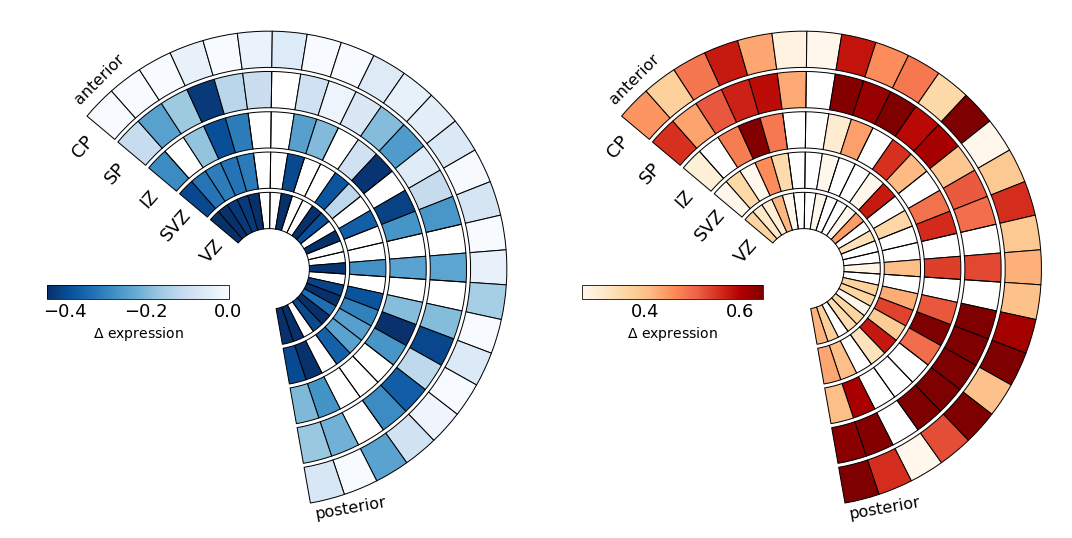

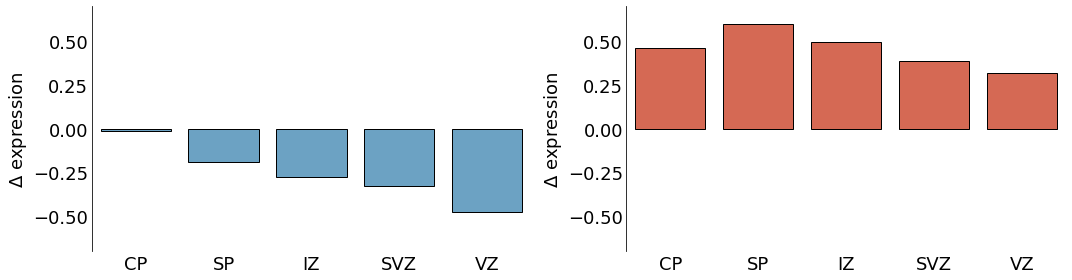

In [21]:
# load A-P position of each cortical label
position_df = pd.read_csv('surface_data/parcellated-axis-data.csv')[['name','AP-axis']]
position_dict = dict(zip(position_df['name'], position_df['AP-axis']))
# positive values = anterior positions

# create wedge figure
fig, ax = plt.subplots(1,2, figsize=(15,8))
fig2, ax2 = plt.subplots(1,2, figsize=(15,4))

## DECREASING ZRT GENES #################################################################################
# extract data for genes with expression that decreases over time
plot_df = microarray_data[microarray_data['gene'].isin(ZRT_genes[ZRT_genes['C_age']<0]['gene'])].drop('DS', axis=1)
# separate expression data for 'early' and 'mid' samples
plot_df = plot_df[plot_df['timepoint']=='early'].merge(plot_df[plot_df['timepoint']=='mid'], on=['tissue', 'cortical_region', 'gene'])
# calculate difference between early and mid gestation
plot_df['diff'] = plot_df['expression_y'] - plot_df['expression_x']
# pivot to tissue x region
plot_df = plot_df[['tissue', 'cortical_region', 'gene', 'diff']].pivot_table(index='tissue', columns='cortical_region')
# rearrange for plot
plot_df = plot_df.reindex(['4.ventricular', '3.subventricular', '2.intermediate', '1.subplate', '0.cortical_plate'])
# get position of each parcel for index
index = [position_dict[p[1]] for p in plot_df.columns]

# plot decreasing gene data
wedge_plot(ax[0], plot_df.values, np.array(index), 
           data_label=r'$\Delta$ expression', num_regions=26, num_zones=5, 
           color_palette='Blues_r', start_degree=140, end_degree=-80, show_index=False)

# barplot of mean expression over tissue zones
sns.barplot(x=plot_df.index[::-1], y=plot_df.mean(1)[::-1], ax=ax2[0], color='#5da5d1', edgecolor='black')






## INCREASING ZRT GENES #################################################################################
# repeat with increasing genes (ANOVA coefficient > 0)
plot_df = microarray_data[microarray_data['gene'].isin(ZRT_genes[ZRT_genes['C_age']>0]['gene'])].drop('DS', axis=1)
# split by age
plot_df = plot_df[plot_df['timepoint']=='early'].merge(plot_df[plot_df['timepoint']=='mid'], on=['tissue', 'cortical_region', 'gene'])
# calculate mean difference
plot_df['diff'] = plot_df['expression_y'] - plot_df['expression_x']
# pivot and rearrange
plot_df = plot_df[['tissue', 'cortical_region', 'gene', 'diff']].pivot_table(index='tissue', columns='cortical_region', )
plot_df = plot_df.reindex(['4.ventricular', '3.subventricular', '2.intermediate', '1.subplate', '0.cortical_plate'])
index = [position_dict[p[1]] for p in plot_df.columns]

# plot
wedge_plot(ax[1], plot_df.values, np.array(index), 
           data_label=r'$\Delta$ expression', num_regions=26, num_zones=5, 
           color_palette='OrRd', start_degree=140, end_degree=-80, show_index=False)

# average expression over tissue zones
sns.barplot(x=plot_df.index[::-1], y=plot_df.mean(1)[::-1], ax=ax2[1], color='#ea5a3f', edgecolor='black')


# formatting
for a in ax:
    a.text(-4.9, 4.1,'anterior', fontsize=FNT-2, rotation=45)
    a.text(1.1, -6.2,'posterior', fontsize=FNT-2, rotation=10)
    
for a in ax2:
    a.set_ylim(-0.7, 0.7)
    a.set_xticklabels(['CP', 'SP', 'IZ', 'SVZ', 'VZ'], fontsize=FNT)
    a.set_xlabel('')
    a.tick_params(which='both', labelsize=FNT, length=0)
    a.set_ylabel(r'$\Delta$ expression', fontsize=FNT)
    sns.despine(ax=a, bottom=True)



#sns.despine(left=True, bottom=True, ax=ax2[0])
fig.tight_layout()
fig2.tight_layout()

fig.savefig('{:}/ZRT-differential-expression-by-timepoint.png'.format(results_dir), dpi=300, transparent=False, facecolor='white')
fig2.savefig('{:}/ZRT-differential-expression-tissue-average.png'.format(results_dir), dpi=300, transparent=False, facecolor='white')
